In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt

data = pd.read_csv("googleplaystore.csv") 


data[data.Category != '1.9']
data= data.replace('-', np.nan)
data= data.replace('Varies with device', np.nan)

data = data.dropna(axis=0, subset=['Type', 'Content Rating', 'Current Ver', 'Android Ver'])
data['Reviews'] = data['Reviews'].astype(str).astype(int)
data['Size'] = data['Size'].astype(str)

## Deal with app size in kilobytes: silce the original dataframe to include only apps that are in kilobytes. ##
## Strip "Size" column of letters, and convert string to float. ##
kilo = copy.deepcopy(data)
kilo = kilo[kilo['Size'].apply(lambda x: 'k' in x)]
kilo['Size'] = kilo['Size'].map(lambda x: x.rstrip('k')) 
kilo["Size"]= pd.to_numeric(kilo["Size"])


## Deal with app size in Megabytes: silce the original dataframe to include only apps that are in Megabytes. ##
## Strip "Size" column of letters, and convert string to float. ##
## Note: we are working with size in kilobytes, hence why the "Size" column gets multiplied by 1000 ##
mega = copy.deepcopy(data)
mega = mega[mega['Size'].apply(lambda x: 'M' in x)]
mega['Size'] = mega['Size'].map(lambda x: x.rstrip('M')) 
mega["Size"]= pd.to_numeric(mega["Size"]) * 1000
 
    
## Stack the two above dataframes to get the full dataframe again ## 
frames = [kilo, mega]
data = pd.concat(frames)


data['Price'] = pd.to_numeric(data['Price'].astype(str).map(lambda x: x.lstrip('$'))) 
data = data.drop(['Current Ver', 'Android Ver', 'Genres'], axis=1)


## Deal with the "Installs" column: strip punctuation/symbols ##
## Since we have an estimate of the number of installs, we will floor the install values ##
data['Installs'] = data['Installs'].astype(str).map(lambda x: x.rstrip('+'))
data["Installs"] = pd.to_numeric(data["Installs"].str.replace(',', ''))


## Make dictionary where key is the app's category, value is the dataframe containing only that category ##
categories = data.Category.unique()
dict_of_categories = {}
for i in categories:
    dict_of_categories['%s' % i] = None
    mask = data['Category'] == i
    cat_vals = data[mask]
    dict_of_categories['%s' % i] = cat_vals

## Get average rating of app for each category ##
avg_ratings = []
for df in dict_of_categories.values():
    mean = df["Rating"].mean()
    avg_ratings.append(mean)


iter_dict = {}
for each in range(0,len(dict_of_categories)-1):
    iter_dict[each] = each
    
## Replace NaN values in the 'Rating' column with the average rating for each category of app ##
filled_in_dict= {}
for (k,v),(k2,v2) in zip(dict_of_categories.items(), iter_dict.items()):
    v = v.fillna(avg_ratings[v2])
    filled_in_dict[k]= v


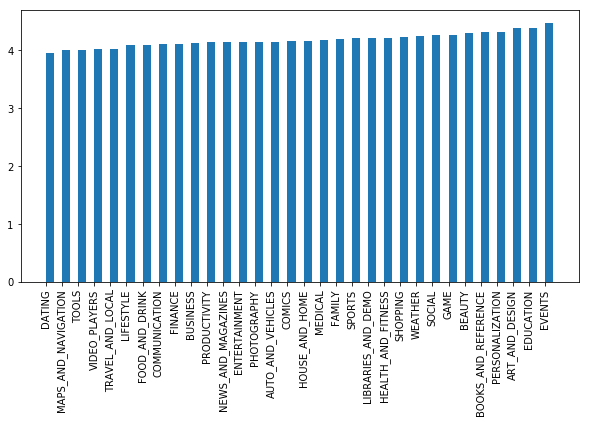

In [2]:
## Graph average ratings for each category of app ###    
## Create rating_dict, where keys are app categories and values are the categorys' average rating ##
## TODO STDEV bars ##
rating_dict = {}

for key, value in filled_in_dict.items():
    rating_dict[key] = value["Rating"].mean()

sorted_rating = {k: v for k, v in sorted(rating_dict.items(), key=lambda x: x[1])} # sort ratings

# make figure
plt.figure(figsize=(10, 5))
plt.xticks(rotation = 90)
plt.bar(sorted_rating.keys(), sorted_rating.values(),align='edge', width=0.5)
plt.show()